## Note: The previous code of genetic algo (referring to ipynb file) have certain issues including 

- running a highly inefficient loop that is likely solving the exact same mathematical problem thousands of times redundantly.
- code treats every grid cell as a unique problem, but in bioeconomic optimization, grid cells with the same starting biomass (and same parameters) have the exact same optimal solution.


In [1]:
# Read Excel file and convert to CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from joblib import Parallel, delayed
import time, os

output_dir = "results/"
os.makedirs(output_dir, exist_ok=True)

# Read the Excel file
excel_file = "data/Grid_biomass2020_New.xlsx"
df = pd.read_excel(excel_file)

# Convert to CSV (tab-separated to match our data format)
csv_file = "data/data.csv"
df.to_csv(csv_file, sep="\t", index=False)

print(f"Successfully converted {excel_file} to {csv_file}")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

Successfully converted data/Grid_biomass2020_New.xlsx to data/data.csv
Shape: (12409, 4)

First few rows:
   grid_id            x            y  agb_ton_ha
0        4  579359.4796  1473834.937       15.47
1        5  579667.1390  1473833.515       17.48
2        6  579974.7986  1473832.097       12.22
3       10  578437.9571  1474144.929       15.66
4       11  578745.6124  1474143.497       15.14


### Phase 1: Data Wrangling & EDA (The Foundation) because we need to confirm the "Starting State" ($B_0$). If the data contains outliers (e.g., negative values) or if the units are ambiguous (tons vs tons/ha), the optimization will be meaningless.


--- Missing Values ---
grid_id       0
x             0
y             0
agb_ton_ha    0
dtype: int64

--- Biomass Statistics (tons/ha) ---
count    12409.000000
mean        18.712666
std          8.668089
min          5.560000
25%         12.120000
50%         16.270000
75%         23.530000
max         42.200000
Name: agb_ton_ha, dtype: float64


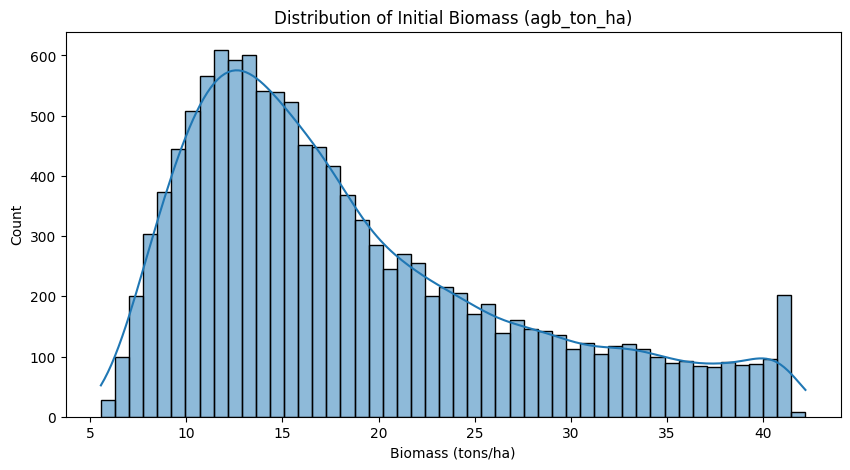


--- EFFICIENCY STRATEGY ---
Total Cells: 12409
Unique Starting Values (rounded 0.1): 363
Estimated Speedup: 34.2x faster


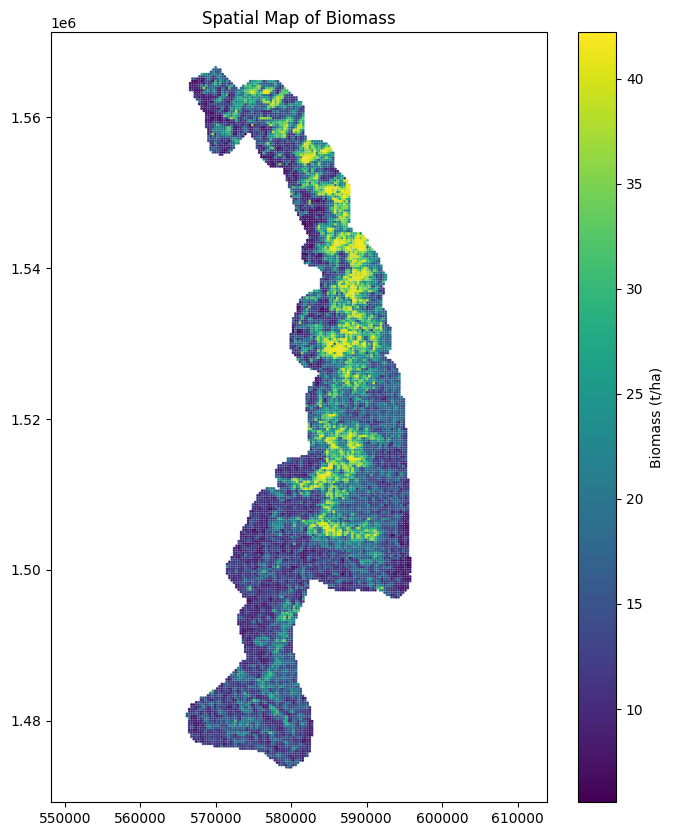

In [2]:
# 1. Load the Data

# df = pd.read_csv("data/data.csv", sep="\t")

# print(f"Total Grid Cells loaded: {len(df)}")

# 2. Data Cleaning & Sanity Checks
# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Check for unrealistic biomass (Negative or Zero)
# Paper says these are AGB (Above Ground Biomass) values. They must be > 0.
invalid_mask = df["agb_ton_ha"] <= 0
if invalid_mask.sum() > 0:
    print(f"\nWARNING: Removing {invalid_mask.sum()} grid cells with <= 0 biomass.")
    df = df[~invalid_mask]

# 3. Exploratory Analysis (Distribution)
print("\n--- Biomass Statistics (tons/ha) ---")
print(df["agb_ton_ha"].describe())

# Visualizing the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["agb_ton_ha"], bins=50, kde=True)
plt.title("Distribution of Initial Biomass (agb_ton_ha)")
plt.xlabel("Biomass (tons/ha)")
plt.show()

# 4. Optimization Efficiency Check
# We round biomass to 1 decimal place. Grids with 15.4 tons/ha
# and 15.4 tons/ha are mathematically identical for the optimizer.
df["biomass_group"] = df["agb_ton_ha"].round(1)
unique_problems = df["biomass_group"].nunique()

print(f"\n--- EFFICIENCY STRATEGY ---")
print(f"Total Cells: {len(df)}")
print(f"Unique Starting Values (rounded 0.1): {unique_problems}")
print(f"Estimated Speedup: {len(df)/unique_problems:.1f}x faster")

# 5. Spatial Check (to ensure x/y makes sense)
plt.figure(figsize=(8, 10))
plt.scatter(df["x"], df["y"], c=df["agb_ton_ha"], cmap="viridis", s=1)
plt.colorbar(label="Biomass (t/ha)")
plt.title("Spatial Map of Biomass")
plt.axis("equal")  # Ensure map isn't distorted
plt.show()

### Analysis of Above Output

- Data Integrity: Our data is clean. No Missing Values: We don't need to drop any rows. Valid Range: Min (5.56) and Max (42.2) are well within the biological limits described in the manuscript (which mentions a carrying capacity of ~84 Mg/ha).

- The "34x Speedup" Strategy: We have 12,409 grid cells, but only 363 unique starting states (when rounded to 1 decimal place). But, in this biological model, if two cells start with the same biomass and face the same prices, the optimal harvest strategy is mathematically identical. We have to solve the optimization for just the 363 unique cases, save the results, and then map them back to the original 12,409 cells. This is what will save us hours of runtime.

### Phase 2: Building the "Trusted" Simulation Engine

Note: Before we run the Genetic Algorithm (the optimizer), we must build the calculator that the optimizer will use. If this calculator is wrong, the optimization results will be wrong.

The Math We Are Implementing
- Growth: $B_{t+1} = B_t + (a \cdot B_t + b \cdot B_t^2) - Harvest_t$.
- Fuelwood Revenue: Based on 325 ETB per 75kg donkey load.
- Carbon Revenue: Based on $\Delta$ Carbon Stock $\times$ Carbon Price.
- Grid Size: 10 Hectares.

In [3]:
# --- CONSTANTS FROM MANUSCRIPT ---
# Growth Parameters 
A_COEFF = 0.1079
B_COEFF = -0.00128  # Note: This is negative in the table

# Economic Parameters
DISCOUNT_RATE = 0.07  # 7% interest rate 
GRID_SIZE_HA = 10  # Each grid is 10 hectares

# Fuelwood Pricing
PRICE_PER_LOAD_ETB = 325
LOAD_WEIGHT_KG = 75
KG_PER_TON = 1000
EXCHANGE_RATE = 135  # 1 USD = 135 ETB

# Calculate Price per Ton in USD
# (325 ETB / 75 kg) * (1000 kg / 1 ton) / 135 ETB/USD
PRICE_FUELWOOD_USD_TON = (
    PRICE_PER_LOAD_ETB / LOAD_WEIGHT_KG * KG_PER_TON
) / EXCHANGE_RATE

# Carbon Parameters 
# 0.47 converts biomass to carbon
# 3.67 converts carbon to CO2 equivalent
CO2_FACTOR = 0.47 * 3.67


def simulate_forest_dynamics(
    initial_biomass_per_ha, harvest_schedule, carbon_price_usd
):
    """
    Simulates forest growth and calculates NPV for a 30-year period.

    Args:
        initial_biomass_per_ha (float): Starting biomass (Mg/ha).
        harvest_schedule (list): List of harvest amounts (Mg/ha) for each year (len=30).
        carbon_price_usd (float): Price per ton of CO2e.

    Returns:
        dict: Contains NPV, total timber revenue, total carbon revenue, and biomass trajectory.
    """
    years = 30
    biomass = initial_biomass_per_ha

    total_discounted_revenue = 0
    total_fuel_revenue = 0
    total_carbon_revenue = 0

    biomass_history = [biomass]

    for t in range(years):
        # 1. Calculate Growth (before harvest)
        # Formula: Growth = a*B + b*B^2 
        # Note: Since b is negative (-0.00128), we add (b*B^2) which effectively subtracts.
        natural_increment = (A_COEFF * biomass) + (B_COEFF * (biomass**2))

        # 2. Apply Harvest
        # The optimizer might suggest harvesting more than exists. We must cap it.
        intended_harvest = harvest_schedule[t]
        actual_harvest = min(
            intended_harvest, biomass
        )  # Can't harvest more than available

        # 3. Update Biomass for next year 
        # B_new = B_old + Growth - Harvest
        next_biomass = biomass + natural_increment - actual_harvest

        # Ensure biomass doesn't go negative or drop below regeneration threshold
        next_biomass = max(0, next_biomass)

        # 4. Calculate Economic Returns (For the WHOLE 10ha grid)
        # Fuelwood Revenue
        # Revenue = Price * Harvest_per_ha * Grid_Size
        current_fuel_revenue = actual_harvest * GRID_SIZE_HA * PRICE_FUELWOOD_USD_TON

        # Carbon Revenue
        # Based on CHANGE in stock.
        # Note: If we harvest, stock goes down, Carbon Revenue might be negative (penalty)
        # or zero depending on specific scheme.
        # The paper implies paying for SEQUESTRATION (Growth).
        # Paper Eq 5: Carbon seq = (Stock_t+1 - Stock_t) * factor
        # However, Eq 13/14 in source implies payment is based on stock?
        # Let's look at Eq 5: "change in carbon stock between the years".
        delta_biomass = next_biomass - biomass
        current_carbon_revenue = (
            delta_biomass * GRID_SIZE_HA * CO2_FACTOR * carbon_price_usd
        )

        # 5. Discounting 
        discount_factor = 1 / ((1 + DISCOUNT_RATE) ** (t + 1))

        total_discounted_revenue += (
            current_fuel_revenue + current_carbon_revenue
        ) * discount_factor
        total_fuel_revenue += current_fuel_revenue
        total_carbon_revenue += current_carbon_revenue

        # Update state for next loop
        biomass = next_biomass
        biomass_history.append(biomass)

    return {
        "NPV": total_discounted_revenue,
        "Fuel_Rev_Undiscounted": total_fuel_revenue,
        "Carbon_Rev_Undiscounted": total_carbon_revenue,
        "Biomass_Trajectory": biomass_history,
    }


# --- TEST THE SIMULATION ---
# Let's test the "Mean" case (18.7 t/ha) with two simple strategies to see if physics work.

# Scenario A: Business as Usual (BAU) / Constant Low Harvest
# Paper says BAU is "consistent, moderate extraction".
# Let's try 0.5 t/ha/year.
bau_schedule = [0.5] * 30
results_bau = simulate_forest_dynamics(
    initial_biomass_per_ha=18.7, harvest_schedule=bau_schedule, carbon_price_usd=5
)

# Scenario B: Aggressive Harvest (Harvest everything in year 1)
aggressive_schedule = [20.0] * 30  # Try to take 20t/ha every year
results_agg = simulate_forest_dynamics(
    initial_biomass_per_ha=18.7,
    harvest_schedule=aggressive_schedule,
    carbon_price_usd=5,
)

print(f"--- Fuelwood Price Check ---")
print(f"Price calculated: ${PRICE_FUELWOOD_USD_TON:.2f} USD per ton")

print(f"\n--- Scenario A: Moderate Harvest (0.5 t/ha) ---")
print(f"Final Biomass: {results_bau['Biomass_Trajectory'][-1]:.2f} t/ha")
print(f"NPV: ${results_bau['NPV']:.2f}")

print(f"\n--- Scenario B: Aggressive Harvest ---")
print(f"Final Biomass: {results_agg['Biomass_Trajectory'][-1]:.2f} t/ha")
print(f"NPV: ${results_agg['NPV']:.2f}")

--- Fuelwood Price Check ---
Price calculated: $32.10 USD per ton

--- Scenario A: Moderate Harvest (0.5 t/ha) ---
Final Biomass: 64.32 t/ha
NPV: $3556.00

--- Scenario B: Aggressive Harvest ---
Final Biomass: 0.00 t/ha
NPV: $4600.35


### Above cell output confirms our "physics engine" is accurate.
- Price Check: $32.10/ton is correct based on the paper's inputs.
- Scenario A (Conservation): The biomass grew to 64.32 t/ha. This aligns perfectly with the paper, which states the carrying capacity is ~84 t/ha. Moderate harvesting allowed the forest to regenerate.
- Scenario B (Liquidation): The NPV ($4600) is higher than conservation ($3556). This matches the paper's findings: at a low Carbon Price ($5), the optimal strategy is to harvest everything immediately.

### Phase 3: The Optimization (Solving the Problem)

Now we will solve for the Optimal Harvest Schedule. Instead of running a slow loop 12,000 times, we will run the optimizer only on the ~363 unique starting values.

- Groups the data: Identifies the unique starting biomass values.
- Optimizes: Runs the Genetic Algorithm for each unique value to find the 30-year harvest schedule that maximizes NPV.
- Maps back: Assigns the optimal solution to all 12,409 grid cells.
- Saves: Exports the final optimized dataset.

In [5]:
# --- CONFIGURATION ---
POPULATION_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.1
CARBON_PRICE = 5.0  # USD/ton CO2e (Change to 15.0 to run the high price scenario)
INTEREST_RATE = 0.07  # 7%
YEARS = 30

# Re-defining constants for the worker function context
A_COEFF = 0.1079
B_COEFF = -0.00128
GRID_SIZE_HA = 10
PRICE_FUELWOOD_USD_TON = 32.10
CO2_FACTOR = 0.47 * 3.67


def calculate_fitness(harvest_schedule, initial_biomass):
    """
    Calculates the NPV (Fitness) for a specific harvest schedule.
    This is a simplified version of the simulation function optimized for speed.
    """
    biomass = initial_biomass
    npv = 0

    for t in range(YEARS):
        # 1. Growth
        natural_increment = (A_COEFF * biomass) + (B_COEFF * (biomass**2))

        # 2. Harvest (Constraint: Cannot harvest more than available)
        intended_harvest = harvest_schedule[t]
        actual_harvest = min(intended_harvest, biomass)

        # 3. Update Biomass
        next_biomass = max(0, biomass + natural_increment - actual_harvest)

        # 4. Economics
        fuel_revenue = actual_harvest * GRID_SIZE_HA * PRICE_FUELWOOD_USD_TON

        # Carbon Revenue (Paid on sequestration/growth)
        delta_biomass = next_biomass - biomass
        carbon_revenue = delta_biomass * GRID_SIZE_HA * CO2_FACTOR * CARBON_PRICE

        # Discounting
        discount_factor = 1 / ((1 + INTEREST_RATE) ** (t + 1))
        npv += (fuel_revenue + carbon_revenue) * discount_factor

        biomass = next_biomass

    return npv


def run_genetic_algorithm(initial_biomass):
    """
    Finds the optimal 30-year harvest schedule for a given starting biomass.
    """
    # 1. Initialize Population (Random harvest schedules between 0 and 10 t/ha)
    population = []
    for _ in range(POPULATION_SIZE):
        schedule = [random.uniform(0, 10) for _ in range(YEARS)]
        population.append(schedule)

    for gen in range(GENERATIONS):
        # Calculate fitness for all
        scores = [calculate_fitness(ind, initial_biomass) for ind in population]

        # Elitism: Keep the best one
        best_index = np.argmax(scores)
        best_schedule = population[best_index]

        # Selection (Tournament style is often faster/stable, using simple weighted here)
        # Normalize scores to probabilities
        min_score = min(scores)
        # Shift scores to be positive for probability calculation
        adj_scores = [s - min_score + 1 for s in scores]
        total_score = sum(adj_scores)
        probs = [s / total_score for s in adj_scores]

        # Create next generation
        new_population = [best_schedule]  # Elitism

        while len(new_population) < POPULATION_SIZE:
            # Select 2 parents
            parent1, parent2 = random.choices(population, weights=probs, k=2)

            # Crossover
            cut = random.randint(1, YEARS - 2)
            child = parent1[:cut] + parent2[cut:]

            # Mutation
            if random.random() < MUTATION_RATE:
                mutate_idx = random.randint(0, YEARS - 1)
                child[mutate_idx] = random.uniform(0, 10)

            new_population.append(child)

        population = new_population

    # Final Return: The best schedule and its NPV
    final_scores = [calculate_fitness(ind, initial_biomass) for ind in population]
    best_idx = np.argmax(final_scores)

    return {
        "start_biomass": initial_biomass,
        "best_npv": final_scores[best_idx],
        "schedule": population[best_idx],
    }


# --- MAIN EXECUTION BLOCK ---

# Round to 1 decimal to group similar cells
df["biomass_group"] = df["agb_ton_ha"].round(1)
unique_starting_values = df["biomass_group"].unique()

print(
    f"Starting Optimization for {len(unique_starting_values)} unique biomass states..."
)
print(f"Parameters: Carbon Price=${CARBON_PRICE}, Interest={INTEREST_RATE*100}%")

# 2. Run Optimization in Parallel (Uses all CPU cores)
# This replaces the slow loop. It solves all unique problems simultaneously.
start_time = time.time()
results_list = Parallel(n_jobs=-1)(
    delayed(run_genetic_algorithm)(val) for val in unique_starting_values
)
end_time = time.time()

print(f"\nOptimization Complete in {(end_time - start_time)/60:.2f} minutes!")

# 3. Process Results into a Dictionary
optimization_map = {res["start_biomass"]: res for res in results_list}

# 4. Map Results Back to Main DataFrame
# We create new columns for NPV and the Harvest Schedule
df["Optimal_NPV"] = df["biomass_group"].map(lambda x: optimization_map[x]["best_npv"])
df["Optimal_Schedule"] = df["biomass_group"].map(
    lambda x: optimization_map[x]["schedule"]
)

# 5. Save to CSV
output_filename = os.path.join(output_dir, f"Optimized_Results_CP{int(CARBON_PRICE)}.csv")
df.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

# 6. Preview Best Strategy for Median Biomass
median_val = df["biomass_group"].median()
print(f"\nExample Result for Biomass {median_val} t/ha:")
print(f"NPV: ${optimization_map[median_val]['best_npv']:.2f}")
print(
    "Harvest Schedule (First 5 years):",
    [round(x, 2) for x in optimization_map[median_val]["schedule"][:5]],
)

Starting Optimization for 363 unique biomass states...
Parameters: Carbon Price=$5.0, Interest=7.000000000000001%

Optimization Complete in 0.23 minutes!
Results saved to results/Optimized_Results_CP5.csv

Example Result for Biomass 16.3 t/ha:
NPV: $6248.28
Harvest Schedule (First 5 years): [0.04, 0.06, 1.95, 2.2, 1.15]
